In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import importlib as imp
import generator as gen
import data_visualization as viz
import multiclass_logistic_regression as mlr

# GOAL
Implémenter SDCA pour la classification multiclasse de base (en regularisant le biais).

## Generate data

In [2]:
imp.reload(gen)
imp.reload(viz)
imp.reload(mlr)
pass

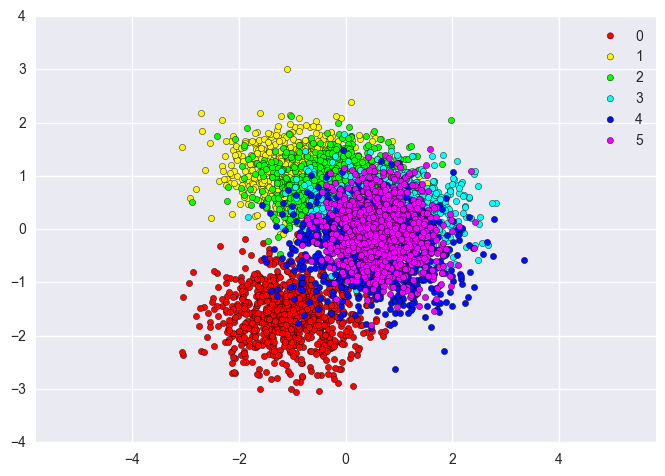

In [3]:
n = 5000
d = 20
k = 6
bias = 1
x,y,mu,sig = gen.gengaussianmixture(n,d,k,scale=.01,randomcov=True)
x = gen.standardize(x)
x = np.concatenate([x, bias*np.ones([n, 1])], axis=1)
viz.plot_data(x,y)

## Line Search
The function for which we want to find a zero is of the form : 

$$u(\gamma) = - \gamma\frac{\|\Delta_i\|^2\|x_i\|^2}{\lambda n}+\frac{\Delta_i^TWx_i}{\lambda n} -\sum_y \Delta_i(y)\log(\alpha_i(y)+\gamma\Delta_i(y)) $$
$$u(\gamma) = - \gamma a + b - \sum_y \Delta_i(y)\log(\alpha_i(y)+\gamma\Delta_i(y))$$
$$u'(\gamma) = -a - \sum_y \frac{\Delta_y^2}{\alpha_i(y) + \gamma \Delta_i(y)}$$

where $\Delta_i$ is the ascent direction, W is the primal parameter matrix and $\gamma$ is the search parameter in [0,1]. The linear coefficient a is always positive. 
Since the zero of this decreasing function can be out of [0,1], we stop the line search with $\gamma =1$ if $u(1)\geq0$, and with $\gamma=0$ if $u(0)\leq 0$.

In [4]:
imp.reload(mlr)

<module 'multiclass_logistic_regression' from '/Users/remilepriol/Dropbox/intership2017/code/multiclass_logistic_regression.py'>

## Test SDCA

In [15]:
imp.reload(mlr)

<module 'multiclass_logistic_regression' from '/Users/remilepriol/Dropbox/intership2017/code/multiclass_logistic_regression.py'>

In [16]:
reg = 1/n

In [17]:
model = mlr.MulticlassLogisticRegression(reg,x,y)

In [18]:
model.w = np.random.randn(k,d+1)
print(model.negloglikelihood(x,y))
condprob = model.conditional_probabilities(x)
model.alpha = condprob
print(model.entropy())
print(model.duality_gap(x,y))

3.65779897962
[ 0.66901929  0.77021767  0.34371002 ...,  1.22260889  0.68342044
  0.64105506]
3.08142866938


In [19]:
#alpha0 = np.zeros([n,k])
alpha0 = np.random.rand(n,k)
alpha0 /= np.sum(alpha0,axis=1,keepdims=True)

In [20]:
obj_sdca,time_sdca = model.sdca(alpha0,x,y,precision=1e-8,debug=False)

Perfect line search : 140003 	 Negative ls : 6 	 Positive ls : 4991


In [21]:
obj_nonuniform, time_nonuniform = model.sdca(alpha0,x,y,precision=1e-8,debug=False,nonuniform=True)

Perfect line search : 60009 	 Negative ls : 5 	 Positive ls : 4986


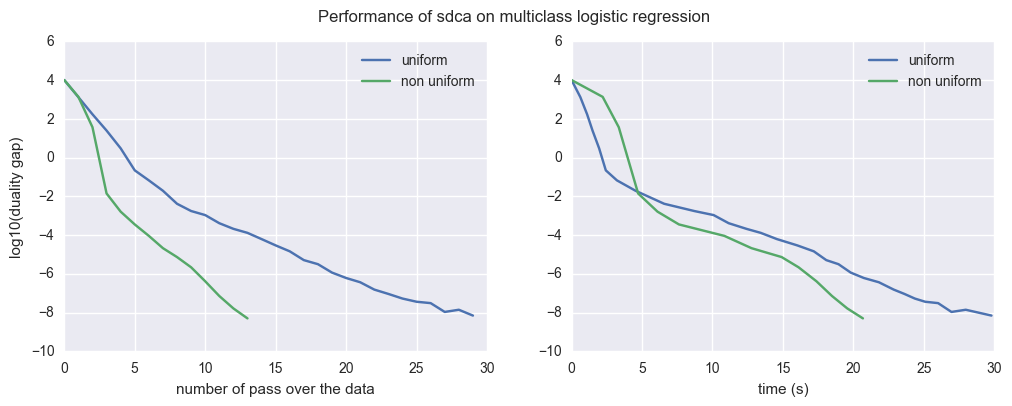

In [22]:
plt.figure(figsize=(12,4))
plt.suptitle("Performance of sdca on multiclass logistic regression")
plt.subplot(1,2,1)
plt.ylabel("log10(duality gap)")
plt.plot(np.log10(obj_sdca),label='uniform')
plt.plot(np.log10(obj_nonuniform),label='non uniform')
plt.legend()
plt.xlabel("number of pass over the data")
plt.subplot(1,2,2)
plt.plot(time_sdca,np.log10(obj_sdca),label='uniform')
plt.plot(time_nonuniform,np.log10(obj_nonuniform),label='non uniform')
plt.legend()
plt.xlabel("time (s)")
#plt.savefig("nonuniform_is_better.pdf")

In [13]:
obj_sdca[-1]

7.252807320435456e-09

ValueError: shapes (40000,3) and (21,6) not aligned: 3 (dim 1) != 21 (dim 0)

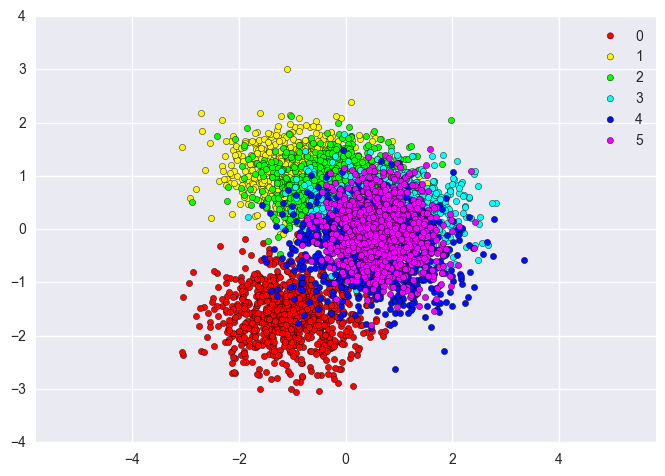

In [14]:
resolution = 200
viz.plot_data(x,y)
viz.plot_areas(model.prediction,bias,resolution)

In [30]:
import sklearn.linear_model as skl

Mon algorithme impose une pénalité bien plus importante à w que scikit learn, alors qu'ils ont la même variable de régularisation égale à 1. sklearn ne divise pas par n la somme des loglikelihoods (ie il prend la somme et non pas la moyenne) ! Il faut donc que je mette reg = 1/n pour être à armes égales.

In [31]:
skreg = skl.LogisticRegression(fit_intercept=False,multi_class='multinomial',solver='sag',C=1/n/reg)
skreg.fit(x,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

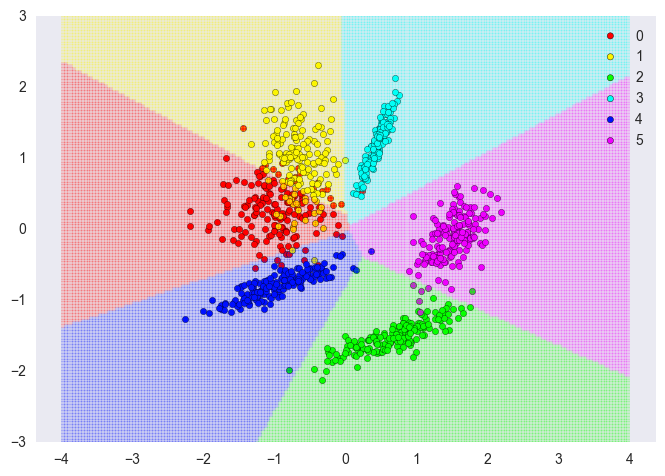

In [32]:
viz.plot_data(x,y)
viz.plot_areas(skreg.predict,bias,resolution)

In [33]:
print("score of sklearn :",skreg.score(x,y))
save_coefs = skreg.coef_
skreg.coef_ = model.w
print("score of sdca :",skreg.score(x,y))
skreg.coef_ = save_coefs

score of sklearn : 0.928
score of sdca : 0.928


In [34]:
save_coefs = model.w
model.w = skreg.coef_
print("objective of sklearn :",model.primal_objective(x,y))
model.w = save_coefs
print("objective of sdca :",model.primal_objective(x,y))

objective of sklearn : 0.33466458128
objective of sdca : 0.334664551548
